For this activity, I used the GroupLens dataset **“Learning from Sets of Items in Recommender Systems.”** The dataset contains user–item–rating interactions, which made it straightforward to load into SURPRISE using the required (user, item, rating) format. To improve runtime during experimentation, I randomly sampled **1,000 ratings** from the dataset.

Choose one so that it is easy to create the data as expected in `Surprise` with user, item, and rating information.  Then, compare the performance of at least the `KNNBasic`, `SVD`, `NMF`, `SlopeOne`, and `CoClustering` algorithms to build your recommendations.  

For more information on the algorithms see the documentation for the algorithm package [here](https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html).

### Setting up data and algorithm paramters

In [ ]:
from surprise import Dataset, Reader, SVD, NMF, KNNBasic, SlopeOne, CoClustering
from surprise.model_selection import cross_validate, RandomizedSearchCV
import time
from scipy.stats import randint, uniform
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:

# Define the file path for the uploaded ratings dataset
file_path = 'data/ratings.csv'

# Load the dataset using pandas to check the structure
ratings = pd.read_csv(file_path)

ratings = ratings.sample(n=1000, random_state=42)  # or frac=0.3
# Define the reader format for the dataset
reader = Reader(line_format='user item rating timestamp', sep=',')

# Load the dataset from the file
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [ ]:
param_dists = {
    'KNNBasic': {
        'k': randint(20, 41),
        'min_k': randint(1, 6),
        'sim_options': {
            'name': ['msd', 'cosine', 'pearson'],
            'user_based': [False, True]
        }
    },
    'SVD': {
        'n_factors': randint(50, 151),
        'n_epochs': randint(20, 31),
        'lr_all': uniform(0.005, 0.005),
        'reg_all': uniform(0.02, 0.03)
    },
    'NMF': {
        'n_factors': randint(10, 31),
        'n_epochs': randint(20, 51),
        'biased': [False, True]
    },
    'CoClustering': {
        'n_cltr_u': randint(3, 8),
        'n_cltr_i': randint(3, 8),
        'n_epochs': randint(20, 31)
    }
}

### Training pipeline

In [ ]:
algo_classes = {
    'KNNBasic': KNNBasic,
    'SVD': SVD,
    'NMF': NMF,
    'CoClustering': CoClustering
}

# Perform randomized search for each algorithm and measure training time
best_algorithms = {}
training_times = {}
testing_times = {}
for algo_name, param_dist in param_dists.items():
    print(f"Performing randomized search for {algo_name}...")
    start_time = time.time()
    rs = RandomizedSearchCV(algo_classes[algo_name], param_dist, measures=['mse'], cv=5, n_iter=20, random_state=42)
    rs.fit(data)
    end_time = time.time()
    best_algorithms[algo_name] = rs.best_estimator['mse']
    training_times[algo_name] = end_time - start_time
    testing_times[algo_name] = 0  # Initialize test time
    print(f"Best parameters for {algo_name}: {rs.best_params['mse']}")
    print(f"Training time for {algo_name}: {training_times[algo_name]:.2f} seconds")
    print("\n")

# Add SlopeOne to the best algorithms as it has no parameters to tune
best_algorithms['SlopeOne'] = SlopeOne()
training_times['SlopeOne'] = 0  # We won't measure the training time for SlopeOne as it has no parameters
testing_times['SlopeOne'] = 0  # Initialize test time for SlopeOne

# Perform cross-validation for the best algorithms found and measure training and testing times
results = {}
for algo_name, best_algo in best_algorithms.items():
    print(f"Evaluating {algo_name} with best parameters...")
    start_train_time = time.time()
    cv_results = cross_validate(best_algo, data, measures=['MSE'], cv=5, verbose=True)
    end_train_time = time.time()

    # Sum up training and testing times
    training_times[algo_name] += (end_train_time - start_train_time) - sum(cv_results['fit_time'])
    testing_times[algo_name] += sum(cv_results['test_time'])

    results[algo_name] = cv_results['test_mse']
    print(f"Total training time for {algo_name}: {training_times[algo_name]:.2f} seconds")
    print(f"Total testing time for {algo_name}: {testing_times[algo_name]:.2f} seconds")

# Find the optimal algorithm
optimal_algo = min(results, key=lambda x: results[x].mean())
optimal_mse = results[optimal_algo].mean()

print("\nOptimal Algorithm: ", optimal_algo)
print("Optimal Mean Squared Error (MSE): ", optimal_mse)
print("Training time for the optimal algorithm: {:.2f} seconds".format(training_times[optimal_algo]))
print("Testing time for the optimal algorithm: {:.2f} seconds".format(testing_times[optimal_algo]))

Performing randomized search for KNNBasic...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity m

      Algorithm  Mean MSE   Std MSE  Training Time (s)  Testing Time (s)
0      KNNBasic  1.090489  0.046397           0.327821          0.004990
1           SVD  1.043394  0.081062           0.774987          0.003085
2           NMF  1.084176  0.104499           3.891717          0.003442
3  CoClustering  1.265342  0.186135           7.553185          0.002631
4      SlopeOne  1.138243  0.086192           0.009789          0.003919


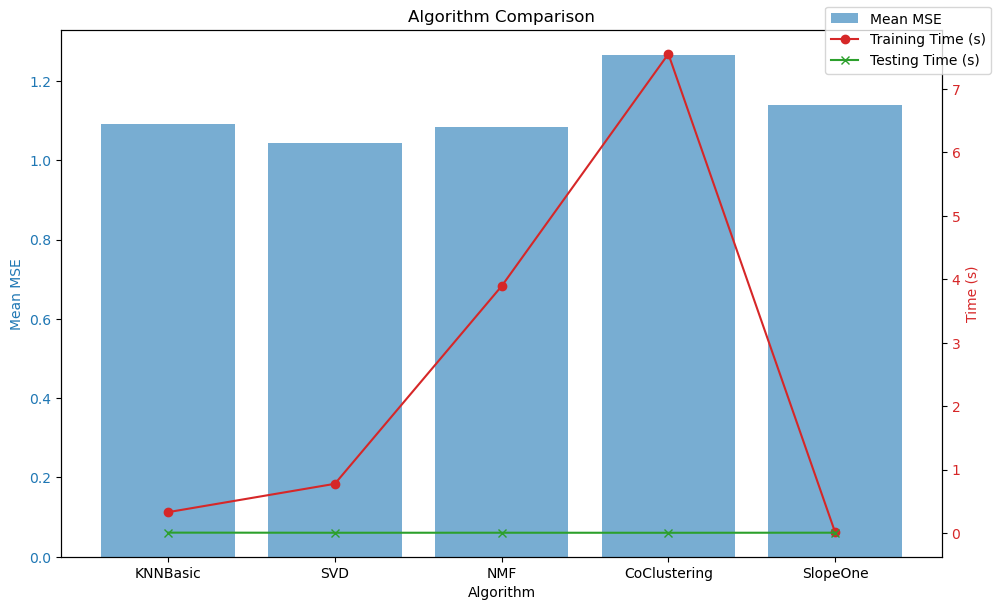

In [ ]:

# Create a DataFrame to display the results
df_results = pd.DataFrame({
    'Algorithm': list(results.keys()),
    'Mean MSE': [results[algo].mean() for algo in results],
    'Std MSE': [results[algo].std() for algo in results],
    'Training Time (s)': [training_times[algo] for algo in results],
    'Testing Time (s)': [testing_times[algo] for algo in results]
})

# Display the DataFrame
print(df_results)

# Visualization
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Algorithm')
ax1.set_ylabel('Mean MSE', color=color)
ax1.bar(df_results['Algorithm'], df_results['Mean MSE'], color=color, alpha=0.6, label='Mean MSE')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Time (s)', color=color)  # we already handled the x-label with ax1
ax2.plot(df_results['Algorithm'], df_results['Training Time (s)'], color=color, marker='o', label='Training Time (s)')
ax2.plot(df_results['Algorithm'], df_results['Testing Time (s)'], color='tab:green', marker='x', label='Testing Time (s)')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(loc='upper right')
plt.title('Algorithm Comparison')
plt.show()

I compared KNNBasic, SVD, NMF, SlopeOne, and CoClustering using 5-fold cross-validation and minimized Mean Squared Error (MSE). After hyperparameter tuning with randomized search, the results were:

* **SVD**: Mean MSE = 1.043 (Std = 0.081)
* KNNBasic: Mean MSE = 1.090
* NMF: Mean MSE = 1.084
* SlopeOne: Mean MSE = 1.138
* CoClustering: Mean MSE = 1.265

SVD achieved the lowest MSE and demonstrated stable performance across folds, making it the optimal algorithm for this dataset. Although CoClustering and NMF required longer training times, they did not outperform SVD. SlopeOne trained extremely quickly but had higher error.

Overall, matrix factorization (SVD) provided the best balance between accuracy and computational efficiency for this sampled dataset.
